# A Face Detection Pipeline

Real-world datasets are noisy, may have missing features, and may be in a form that is difficult to map to a clean ``[n_samples, n_features]`` matrix.

We will review an image feature extraction technique, the [Histogram of Oriented Gradients](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients) (HOG). It transforms image pixels into a vector representation that is sensitive to broadly informative image features regardless of confounding factors like illumination.

We will use these features to develop a simple face detection pipeline.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

### HOG

- Histogram of Gradients is a feature extraction technique that was developed to identify pedestrians within images. It uses the following steps:

    1. __Pre-normalize images__ (optional). This leads to features that resist dependence on variations in illumination.
    2. __Convolve images__ with two filters that are sensitive to horizontal and vertical brightness gradients. These capture edge, contour, and texture information.
    3. __Subdivide images__ into cells of predetermined size & build a histogram of the gradient orientations within each cell.
    4. __Normalize histograms__ in each cell by comparing to the block of neighboring cells. This further suppresses the effect of illumination across the image.
    5. __Construct one-dimensional feature vector__ from the information in each cell.

/home/bjpcjp/miniconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


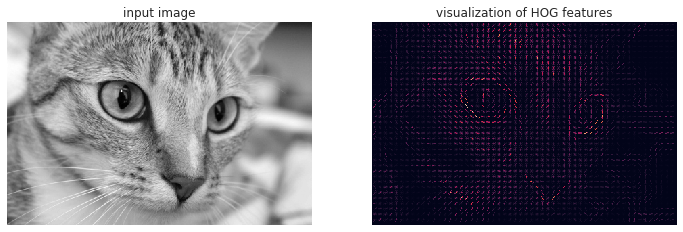

In [2]:
from skimage import data, color, feature
import skimage.data

image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualise=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');

### HOG in Action: A Simple Face Detector

Use a linear __support vector machine__ to build the facial detection algorithm:

1. Get a set of image thumbnails of faces, ie "positive" training samples.
2. Get a set of image thumbnails of non-faces, ie "negative" training samples.
3. Extract HOG features from the training samples.
4. Train a linear SVM classifier on the samples.
5. For an "unknown" image, pass a sliding window across the image, using the model to evaluate whether that window contains a face or not.
6. If detections overlap, combine them into a single window.

Let's go through these steps and try it out:

### 1. Obtain a set of positive training samples

Let's start by finding some positive training samples that show a variety of faces. Use the Labeled Faces in the Wild dataset.

In [3]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

This gives us 13,000 face images.

### 2. Obtain a set of negative training samples

We need a set of similarly sized thumbnails which *do not* have a face in them. One way to do this is to take any corpus of images and extract thumbnails from them at a variety of scales.
Here we can use some of the images shipped with Scikit, along with Scikit's ``PatchExtractor``:

In [4]:
from skimage import data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

In [5]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

/home/bjpcjp/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(30000, 62, 47)

We now have 30,000 image patches which do not contain faces. Let's take a look at a sample.

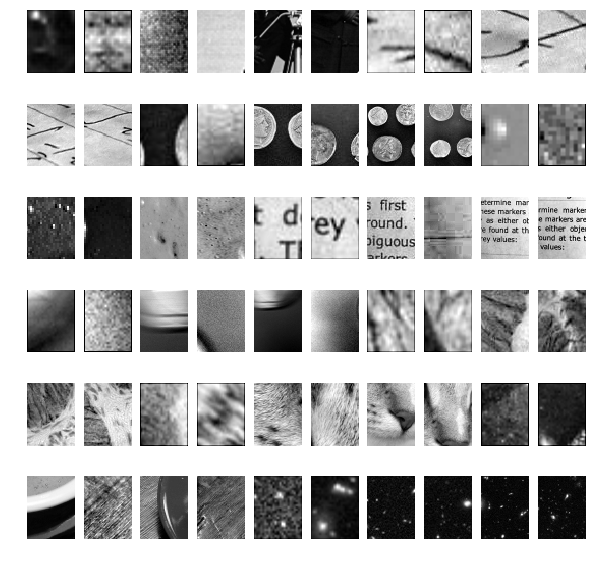

In [7]:
fig, ax = plt.subplots(6, 10, figsize=(10,10))
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

Our hope is that these would sufficiently cover the space of "non-faces" that our algorithm is likely to see.

### 3. Combine sets and extract HOG features

Combine the positive & negative samples and compute HOG features. This step takes a little while - HOG features require a nontrivial computation for each image:

In [8]:
from itertools import chain
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

/home/bjpcjp/miniconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [9]:
X_train.shape

(43233, 1215)

We now have 43,000 training samples in 1,215 dimensions.

### 4. Training a support vector machine

Next we need to build a classifier of thumbnail patches. For such a high-dimensional binary classification task, a __Linear support vector machine__ is a good choice.

Let's use __Scikit's ``LinearSVC``__. Compared to ``SVC`` it often has better scaling for large number of samples.

First, let's use a __Gaussian naive Bayes__ to get a quick baseline:

In [12]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train)

array([ 0.94684616,  0.91423218,  0.94073971])

__The simple naive Bayes algorithm gets us >90% accuracy.__

Let's try the support vector machine with a grid search over the C parameter:

In [14]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

0.9864224088080864

In [15]:
grid.best_params_

{'C': 2.0}

Let's take the best estimator and re-train it on the full dataset:

In [16]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=2.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

### 5. Find faces in a new image

Now that we have a trained model, let's grab a new image and see how it does.

Use one portion of the astronaut image for simplicity, run a sliding window over it, and evaluate each patch:

/home/bjpcjp/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


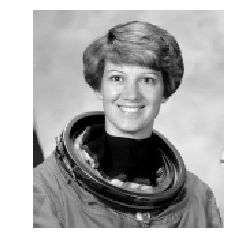

In [17]:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off');

Create a window that iterates over the image patches and compute HOG features for each patch:

In [18]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

/home/bjpcjp/miniconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(1911, 1215)

Take the HOG-featured patches and use our model to evaluate whether each patch contains a face:

In [19]:
labels = model.predict(patches_hog)
labels.sum()

31.0

Out of nearly 2,000 patches, __we found 30 detections__. Let's use the information we have about these patches to show where they lie on our test image, drawing them as rectangles:

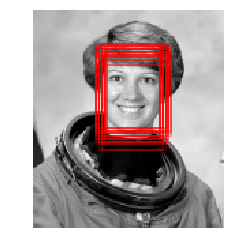

In [20]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

All of the detected patches overlap and found the face in the image!
Not bad for a few lines of Python.

### Caveats and Improvements

We still have several issues & improvements to resolve before releasing this face detector into production:

### Our training set, especially for negative features, is not very complete

There are __many face-like textures that are not in the training set - our current model is susceptible to false positives.__ Test the above algorithm on the *full* astronaut image: the current model leads to many false detections in other regions of the image.

We could add a wider variety of images to the negative training set.

Another method is to use a targeted approach, such as __hard negative mining__. In hard negative mining, we take a new set of images that our classifier has not seen, find all the patches representing false positives, and explicitly add them as negative instances in the training set before re-training the classifier.

### Our current pipeline searches only at one scale

As currently written, our algorithm __will miss faces that are not approximately 62×47 pixels__.
This can be addressed by using sliding windows of a variety of sizes, and re-sizing each patch using __``skimage.transform.resize``__ before feeding it into the model. The ``sliding_window()`` utility is already built with this in mind.

### We should combine overlapped detection patches

We would prefer __not to have 30 detections of the same face__, but to reduce overlapping groups of detections down to a single detection. 

This could be done via an unsupervised clustering approach (__MeanShift Clustering__ is one good candidate for this), or via a procedural approach such as __non-maximum suppression__, an algorithm common in machine vision.

### The pipeline should be streamlined

We should also create a more streamlined pipeline for ingesting training images and predicting sliding-window outputs.

This is where Python as a data science tool really shines: with a bit of work, we could take our prototype code and package it with a well-designed object-oriented API that give the user the ability to use this easily.

### More recent advances: Deep Learning

Note: __HOG and other procedural feature extraction methods for images are no longer state-of-the-art techniques.__

Most modern object detection pipelines use variants of deep neural networks: one way to think of neural networks is that they are an estimator which determines optimal feature extraction strategies from the data, rather than relying on the intuition of the user.